# BEAST Workflow Example

In this notebook we will be walking through a standard BEAST workflow 

Before we do anything, we have to import the following packages. Running them all as the first cell means that if our kernel ever crashes halfway through, we can just reimport everything at once rather than stepping through the cells individually.

In [1]:
import os

import h5py

import numpy as np
from astropy import wcs
from astropy.io import fits
from astropy.table import Table
#import tables

import glob
import types
import argparse

import matplotlib.pyplot as plt
import seaborn as sns

from beast.plotting import (plot_mag_hist, plot_ast_histogram, plot_noisemodel)

from beast.tools.run import (
    create_physicsmodel,
    make_ast_inputs,
    create_obsmodel,
    run_fitting,
    merge_files,
    create_filenames,
)

from beast.physicsmodel.grid import SEDGrid
from beast.fitting import trim_grid
import beast.observationmodel.noisemodel.generic_noisemodel as noisemodel
from beast.observationmodel.observations import Observations


from beast.tools.run import (
    run_fitting,
    merge_files,
)    
    
from beast.tools import beast_settings
from beast.tools import (
     create_background_density_map,
     split_ast_input_file,
     split_catalog_using_map,
#     subdivide_obscat_by_source_density,
     cut_catalogs,
#     split_asts_by_source_density,
     setup_batch_beast_trim,
#     setup_batch_beast_fit,
 )

import importlib
print('Imports complete')

Imports complete


# Step 0. Obtain data file and convert to fits file

Sometimes photometric catalogs are delivered as HDF5 files. While these are great for storing data in heirarchies, it's a little hard to work with directly, so we have to convert our HDF5 file to a FITS file.

Thankfully, our photometric catalog for this example is already in a FITS format so we don't need to worry about this and can move straight on to Step 1.

# Step 1. Start working in the right directory

We want to keep all the files we're working with inside a neat directory structure. So here at beginning, let's make set our data directory to be out current working directory.

In [2]:
working_dir = "/astro/dust_kg/cclark/Leo-P/BEAST_Run/"
os.chdir(working_dir)

Throughout this notebook, we have frequent instances of `os.chdir(working_dir)`, to make certain that we don't have to re-run everything to be sure of finding the files we want. 

# Step 1a. Make magnitude histograms

The first thing we need to do is understand the range of stellar magnitudes we are working with in this data set.

To do this we can make histograms of all the magnitudes of all the stars in all the different filters from the photometric catalog. This is done so that we know where the peaks of the histograms are in each filter. These peaks will then be used later when we make source density maps. 

Essentially what happens is that, for the density maps, we only count objects within a certain range, currently set to mag_cut = 15 - (peak_for_filter-0.5). So if the peak was 17.5, then the objects that would be counted would have to be in the range between 15 and 18. 

The reason we only count brighter sources is because dimmer sources tend to not be properly observed, especially as the magnitudes near the telescope limit. There will always be far more dim sources than bright sources, but if we know how many bright sources there are, then we can extrapolate as to how many dim sources there should be, and probably get a better understand from that than if we were to try and actually count all the dim sources we detect.  

**Variable Information**

* **field_name** : the string name of the main photometric catalog we are working with. This variable will be used to rename a lot of different files in the future which is why we have it as a separate variable.
* **gst_file** : stands for good-stars, this is the full name for the original photometric catalog we are working with.

In [3]:
field_name = "13376_LEOP"
gst_file = "/astro/dust_kg/cclark/Leo-P/BEAST_Run/%s.gst.fits" %field_name

We can see what type of data this fits file holds by making a table. There should be around 50,000 sources in this calalog, which is quite small compared to the original file.

*Note: **st** stands for stars. We also sometimes name things **gst** for good stars to signify when cuts have been made.*

In [4]:
hdul = fits.open(gst_file)
Table(hdul[1].data)

X,Y,RA,DEC,F110W_RATE,F110W_RATERR,F110W_VEGA,F110W_STD,F110W_ERR,F110W_CHI,F110W_SNR,F110W_SHARP,F110W_ROUND,F110W_CROWD,F110W_FLAG,F160W_RATE,F160W_RATERR,F160W_VEGA,F160W_STD,F160W_ERR,F160W_CHI,F160W_SNR,F160W_SHARP,F160W_ROUND,F160W_CROWD,F160W_FLAG,F275W_RATE,F275W_RATERR,F275W_VEGA,F275W_STD,F275W_ERR,F275W_CHI,F275W_SNR,F275W_SHARP,F275W_ROUND,F275W_CROWD,F275W_FLAG,F336W_RATE,F336W_RATERR,F336W_VEGA,F336W_STD,F336W_ERR,F336W_CHI,F336W_SNR,F336W_SHARP,F336W_ROUND,F336W_CROWD,F336W_FLAG,F475W_RATE,F475W_RATERR,F475W_VEGA,F475W_STD,F475W_ERR,F475W_CHI,F475W_SNR,F475W_SHARP,F475W_ROUND,F475W_CROWD,F475W_FLAG,F814W_RATE,F814W_RATERR,F814W_VEGA,F814W_STD,F814W_ERR,F814W_CHI,F814W_SNR,F814W_SHARP,F814W_ROUND,F814W_CROWD,F814W_FLAG,MASK_FLAG
float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int64
1301.61,1201.61,155.43601755,18.08283886,2.45e-06,5.27e-10,14.029,99.999,0.0,1.28,3629.5,0.031,0.011,0.06,0,3.69e-06,5.55e-10,13.581,99.999,0.0,1.07,6237.1,0.04,-0.004,0.068,2,3.86e-08,9.46e-11,18.534,99.999,0.007,2.84,157.7,-0.027,0.046,0.017,2,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,1
1367.06,818.17,155.43051968,18.08420766,3.1e-07,1.52e-10,16.273,99.999,0.003,5.37,432.3,0.089,-0.148,0.087,0,5.67e-07,2.35e-10,15.615,99.999,0.002,4.68,564.5,-0.016,0.1,0.07,0,1.04e-09,1.66e-11,22.452,99.999,0.14,8.31,7.8,-0.049,0.391,0.0,2,4.97e-09,3.14e-11,20.759,99.999,0.13,19.9,8.3,-0.135,0.112,0.001,2,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,1
1571.17,780.66,155.43023305,18.08707709,2.37e-07,1.23e-10,16.562,99.999,0.003,6.13,333.2,-0.025,-0.114,0.003,0,3.87e-07,1.65e-10,16.032,99.999,0.003,5.43,432.1,-0.011,0.068,0.006,0,-4.5e-12,3.38e-12,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,3.46e-10,8.89e-12,23.652,99.999,0.201,7.76,5.4,-0.207,-0.162,0.0,0,8.02e-13,2.75e-13,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,1.71e-10,1.89e-12,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,1
273.83,2032.02,155.44679698,18.0676146,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,2.1e-08,3.18e-11,19.193,99.999,0.002,1.52,435.5,-0.042,0.033,0.004,99,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,0
1300.0,1203.44,155.43604214,18.08281437,6.87e-08,2.23e-10,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,5.37e-08,3.41e-10,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,4.26e-10,2.66e-11,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,7.56e-10,5.98e-11,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,1
3202.32,330.43,155.42575171,18.11018987,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,1.99e-10,7.63e-12,24.254,99.999,0.191,4.93,5.7,-0.094,0.224,0.002,0,3.51e-09,2.37e-11,21.136,99.999,0.093,13.46,11.6,0.012,0.276,0.006,0,0.0,9999.0,99.999,99.999,99.999,99.9

As we can see, there's a lot of columns and even more rows. For plotting the magnitude histograms, we're going to be interested in any column that contains the name VEGA. These are the columns with the magnitudes for each filter.

We could also use the X and Y columns to plot where are the sources are located, or the RA and DEC to map their actual position in the sky.

In larger projects we might have multiple fields to analyze during each run, so there would be multiple **field_names**. Since this is just a small example, we just have one field so our index will always be equal to **0**.

In [5]:
# the list of fields (we only have 1 for this example.)
field_names = [field_name]

Now we can create some histogram plots to visualize the magnitude distribution of our sources.

In [6]:
# this 'if' statement just checks if there's already a histogram file
if not os.path.isfile('./'+field_names[0]+'.st_maghist.pdf'):
    peak_mags = plot_mag_hist.plot_mag_hist(gst_file, stars_per_bin=70, max_bins=75)

You can check out the results for the histograms in the file ending with **_maghist.pdf**

From this plot, we can also see what filters exist for the data. 

# Step 1b. Make source density maps

Next we'll be creating source density maps. These are maps of our data field colored such that they show how many stars/sources there are in each degree field. The standard size is 5 arc seconds squared. The size can easily be changed by modifying the **pixsize** variable below.

In [7]:
# Pick the filter with the dimmest peak from the histogram
ref_filter = ["F475W"]

# choose a filter to use for removing artifacts
# (remove catalog sources with filter_FLAG > 99)
flag_filter = ["F475W"]

In [8]:
# check to see if the source density file already exists
if not os.path.isfile(gst_file.replace(".fits", "_source_den_image.fits")):
    # if not, run all this other code
    
    # - pixel size of 5 arcsec
    # - use ref_filter[b] between vega mags of 15 and peak_mags[ref_filter[b]]-0.5
        # since we're only working with one field, our index b is set to 0
    sourceden_args = types.SimpleNamespace(
        subcommand="sourceden",
        catfile=gst_file,
        pixsize=5,
        npix=None,
        mag_name=ref_filter[0]+ "_VEGA",
        mag_cut=[17, peak_mags[ref_filter[0]] - 0.5],
        flag_name=flag_filter[0]+'_FLAG',
        erode_boundary=False,
        diffSpike=False,
    )
    create_background_density_map.main_make_map(sourceden_args)

# of x & y pixels =  46 43
working on converting ra, dec to pix x,y


In [9]:
# new file name with the source density column
gst_file_sd = gst_file.replace(".fits", "_with_sourceden.fits")

This function should create 3 files: 
* `13376_LEOP.gst_source_den_image.fits` : a file for viewing the source density information in ds9 or with matplotlib

* `13376_LEOP.gst_sourceden_map.hd5` : the same file as source_den_image but now with even more data (the split_catalog_using_map function will end up using this file later on) 

* `13376_LEOP.gst_with_sourceden.fits` : the same as the original photometric file (gst_file) but now with an additional column for what density bin the source is located in

### View the fits images of the source density maps

Now that we have the source density maps outputted, we can plot the image and see that the density looks like.

In [10]:
# open the fits file
hdu_list = fits.open("/astro/dust_kg/cclark/Leo-P/BEAST_Run/%s.gst_source_den_image.fits"%field_name)
hdu_list.info()

# extract the image data
image_data = hdu_list[0].data

# take a look at what the image should look like
print(type(image_data))
print(image_data.shape)

# close the fits file
hdu_list.close()

Filename: /astro/dust_kg/cclark/Leo-P/BEAST_Run/13376_LEOP.gst_source_den_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   (46, 43)   float64   
<class 'numpy.ndarray'>
(43, 46)


Text(0.5, 1.0, 'Density of Sources per 5 arcsec^2')

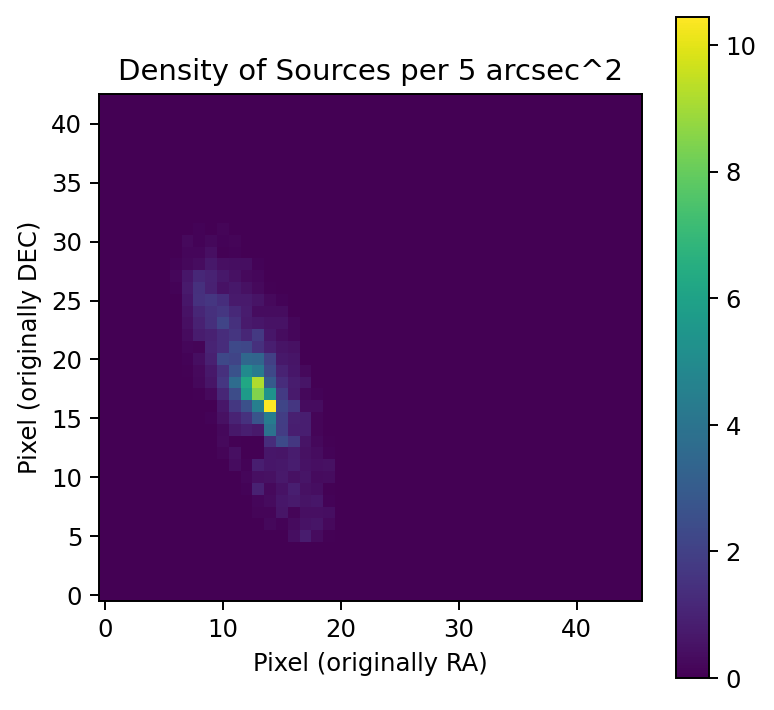

In [11]:
# plot the extracted image data
fig = plt.figure(0, [5,5])
im = plt.imshow(image_data, origin="lower")
plt.colorbar(im)
plt.xlabel("Pixel (originally RA)")
plt.ylabel("Pixel (originally DEC)")
plt.title("Density of Sources per 5 arcsec^2")

# Step 1c. Set up beast_settings.txt file

At this point, we have a basic understanding of the information we are working with, so it's about time we set up our beast_settings.txt file. 

The beast_settings file is a sort of catch-all file used to store any sort of infomation we might need to run the BEAST code on our data. We'll go through and talk about what all the different variables mean, and which ones would need to be changed for any future projects.

Variables labelled AC (either here or in beast_settings.txt) are where the user's input change is NOT necessary/recommended

For convenience, we state the path here, as we'll be updating and reloading this file a few times throughout.

In [1]:
settings_path = "/astro/dust_kg/cclark/Leo-P/BEAST_Run/beast_settings.txt"

Go ahead and open the beast_settings.txt file in a text editor now and ensure that the following variables match:

*  **project** : the same as the field_name variable we noted earlier
    * `project = "13376_LEOP" `
    
    
* **surveyname** : the overall name for the survey (this variable isn't actually important for the code)
    * `surveyname = "Leo_P"*`
    
    
* **filters** : the full filter names from the photometric catalog, also the names that show up in our magnitude histograms so you can add them from there
    * `filters = ["HST_WFC3_F475W", "HST_WFC3_F275W", "HST_WFC3_F336W", "HST_WFC3_F814W", "HST_WFC3_F110W", "HST_WFC3_F160W",]`
    
    
* **base filters** : shortened versions of the filter names
    * `basefilters = ["F475W", "F275W", "F336W", "F814W", "F110W", "F160W"]`
    
    
* **obsfile** : the name of the photometric catalog
    * *`obsfile = "/astro/dust_kg/cclark/Leo-P/Ben_Data/13376_LEOP.gst.fits"`
    
    
* **noisefile** : absflux calibration covariance matrix for HST specific filters (AC)
    * `noisefile = project + "/" + project + "_noisemodel.hd5"`
    
    
* **absflux_a_matrix** : absflux calibration covariance matrix for HST specific filters (AC)
    * `absflux_a_matrix = absflux_covmat.hst_frac_matrix(filters)`
    
    
    

There will be the following parameters common to all methods of AST generation:


* **ast_with_positions** : make sure is set to *True* if you have the locations included in your obsfile
    * `ast_with_positions = True`
    
    
* **ast_realization_per_model** : number of realizations of each included AST model to be put into the list; the default (20) is necessary for truncheon noise model, but one realization is sufficient for the toothpick noise model.
    * `ast_realization_per_model = 1`


* **ast_density_table** : the source density map created in step 1b  
    * `ast_density_table = '"/astro/dust_kg/cclark/Leo-P/Ben_Data/13376_LEOP.gst_sourceden_map.hd5"`
    
    
* **ast_pixel_distribution** : (used if ast_with_positions is True), minimum pixel separation between AST position and catalog star used to determine the AST spatial distribution  
    * `ast_pixel_distribution = 10.0`
    
    
* **ast_reference_image** : the original photometric FITS catalog which is required if you use the ast_with_positions as true  
    * `ast_reference_image = ""/astro/dust_kg/cclark/Leo-P/Ben_Data/13376_LEOP_F475W_drz.fits"*`
    
    
* **astfile** : the file of ASTs we will be creating in step 3, but since ASTs normally have to be processed by a specialist, we have already included a finished AST file for us to use in this example
    * `astfile = "/astro/dust_kg/cclark/Leo-P/BEAST_Run/13376_LEOP.gst.fake.fits"`
    
    
* **ast_colnames** : names of columns for filters in the AST catalog (AC)
    * `ast_colnames = np.array(basefilters)`
    
    
* **n_subgrid** : the number of subgrids to use for generating the physics model later on (with 1 meaning no subgrids); this notebook workflow **requires** n_subgrid >= 2
    * `n_subgrid = 2`
    
    
    

 

For the recommended manner of AST generation, which is by source density binning, there are also the following options to set:

* **sd_binmode** : whether to use linear or logarithmic source density binning
    * *sd_binmode = "log"*
    
    
* **sd_Nbins** : number of bins in source density to use
    * *sd_Nbins = "10"*
    
    
* **sd_binwidth** : width of soruce density bins; only used for linear spacing
    * *sd_binwidth = None*
    
    
* **sd_custom** : width of soruce density bins; only used for linear spacing
    * *sd_custom = None*
    
    
* **ast_n_flux_bins** : number of flux bins into which the dynamic range of the model grid in each filter is divided (if pick_models_toothpick_style is used)
    * *ast_n_flux_bins = 100*  
    
    
* **ast_n_per_flux_bin** : minimum number of model SEDs that need to fall into each bin (if pick_models_toothpick_style is used)
    * *ast_n_per_flux_bin = 50*  
    
    
* **ast_bands_above_maglimit** : number of filters that must be above the magnitude limit for an AST to be included in the list
    * *ast_bands_above_maglimit = 3*  
    
    
* **ast_models_selected_per_age** : number of models to pick per age
    * *ast_models_selected_per_age = 100*  
    
    
    
    

This file is also where you specify the parameters and resolution of your physics model which will become relevant in step 2. The resolution of these parameters for your own runs will differ depending on what sorts of ASTs you want to model. There are 8 parameters that can be set.

1. **Distance** : either a fixed value or a range with stepsizes
2. **Velocity** : what is the heliocentric velocity of your location or galaxy in km/s
3. **Age** : the log10 age range of the ASTs being modeled
4. **Mass** : the mass of the ASTs
5. **Metallicity** : the metallicity range of the ASTs

6. **A(v)** : the range of dust extinction in magnitudes that could be dimming the intrinsic brightness of the ASTs
7. **R(v)** : the range of dust grain sizes 
8. **f(A)** the mixture factor between the Milky Way and Small Magellanic Cloud extinction curves

Our goal after this would normally be to eventually run a bunch of **ASTs** (Artificial Star Tests), but before we can do that, we need to generate the fake stars to use.

Since the ASTs would normally need to be analyzed by a specialist after being created and that's a little overkill for a small example, these next couple of steps are just to illustrate how the ASTs are actually generated. A finished file of the analyzed ASTs already exists so we will end up using that in step 4 and beyond.



# Step 2. Create physics model

In order to generate a diverse and representative sample of fake stars to use for our ASTs, we need to set up a N-dimensional model of possible stellar parameters, so that we can easily and randomly select stars from the model.

This model is called a **physics model**, and we will be using the parameters set in the beast_settings.txt file to create this N-dimensional grid.

*As a quick note, the resolution on the stellar parameters (the step size, often specified as the third input e.g. logt = [6.0, 10.13, 1.0], where 1.0 is the step size) is the main factor driving how long this physics grid will take to set up. If things take a very long time to run, consider making the step size larger for testing's sake.*

Sometimes we are able to have access to high-performance computing resources, meaning we can split the physics model into subgrids and run them in parallel, cutting a lot of the computation time. While we're like not running this notebook in parallel here, we've still specified a number of subgrids in the beast_settings.txt file. 

We can check how many subgrids are set up.

In [13]:
settings = beast_settings.beast_settings(settings_path)
print(settings.n_subgrid)

Padova CMD isochrones
Working on the PARSEC isochrone
2


So we can now see that we've asked for 2 grids in the beast_settings.txt file.

If we've already generated a physics model, we certainly don't want to run it again, so the following code checks to make sure all the subgrids for the physics model are present.

In [14]:
# set up the naming conventions for the physics model
gs_str = ""

# this is only relevant if we run with multiple subgrids
if settings.n_subgrid > 1:
    gs_str = "sub*"

# collects any physics models that have already been created
# if none have, sed_files will be empty
os.chdir(working_dir)
sed_files = glob.glob("./{0}/{0}_seds.grid{1}.hd5".format(field_names[0], gs_str))
print(sed_files)

[]


In [15]:
# only make the physics model if it doesn't already exist
if len(sed_files) < settings.n_subgrid:
    
    # directly create physics model grids
    create_physicsmodel.create_physicsmodel(beast_settings_info=settings_path, nprocs=1, nsubs=settings.n_subgrid)

Padova CMD isochrones
Working on the PARSEC isochrone
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
13376_LEOP/13376_LEOP Isochrones
Make spectra
applying 1 distances
Adding spectral properties: True


Distance grid: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Make Prior Weights
computing the distance plus weights for dist =  1620000.0
computing the age-mass-metallicity grid weight for Z =  0.00015
computing the age-mass-metallicity grid weight for Z =  0.00018
computing the age-mass-metallicity grid weight for Z =  0.00023
computing the age-mass-metallicity grid weight for Z =  0.00029
computing the age-mass-metallicity grid weight for Z =  0.00036
computing the age-mass-metallicity grid weight for Z =  0.00046
computing the age-mass-metallicity grid weight for Z =  0.00058
computing the age-mass-metallicity grid weight for Z =  0.00073
constructing subgrid 0
constructing subgrid 1
Make SEDS
number of initially requested points = 3468
              number of valid points = 1462 (based on restrictions in R(V)
                 versus f_A plane)
              
Generating a final grid of 37488604 points


SED grid: 100%|██████████| 1462/1462 [49:51<00:00,  2.05s/it]


13376_LEOP/13376_LEOP_seds.gridsub0.hd5
Make SEDS
number of initially requested points = 3468
              number of valid points = 1462 (based on restrictions in R(V)
                 versus f_A plane)
              
Generating a final grid of 37488604 points


SED grid: 100%|██████████| 1462/1462 [49:08<00:00,  2.02s/it]


13376_LEOP/13376_LEOP_seds.gridsub1.hd5


In [16]:
# list of SED files (physics models)
model_grid_files = sorted(
    glob.glob(
        "./{0}/{0}_seds.grid{1}.hd5".format(field_names[0], gs_str)
    )
)
sed_files = model_grid_files

Hopefully a spectral grid and an SED grid should have started generating. In the end you should have a new folder with the same name as your project. In it should be various files with names containing "gridsub" followed by a number (unless you have only 1 subgrid).

# Step 3. Create Input ASTs

Now that we have our physics model generated, we can start to generate some input ASTs. ASTs are artificial sources inserted into the observations we have, which are then extracted with the same software that was used for the original photometry catalog. So the step that we're running now is just generating the artifical sources that will then later be inserted. 

We need to make sure that the ASTs cover the same range of magnitudes as our original photometric catalog does, so to do that


First thing's first, we're gonna check that there isn't already a file of AST inputs present in the folder we're working in.

In [17]:
# only create an AST input list if the ASTs don't already exist
ast_input_file = ("./{0}/{0}_inputAST.txt".format(field_names[0]))
print(ast_input_file)

./13376_LEOP/13376_LEOP_inputAST.txt


Now we can create the ASTs if they don't already exist.

In [19]:
os.chdir(working_dir)
if not os.path.isfile(ast_input_file):
    make_ast_inputs.make_ast_inputs(flux_bin_method=True)

In [20]:
ast = Table.read(ast_input_file, format="ascii")
ast

zeros,ones,X,Y,HST_WFC3_F275W,HST_WFC3_F336W,HST_ACS_WFC_F475W,HST_ACS_WFC_F814W,HST_WFC3_F110W,HST_WFC3_F160W
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
0,1,2805.74655,1130.85251,28.21656,27.54473,27.31381,26.30651,25.90955,25.47067
0,1,1634.70799,1651.23957,28.21656,27.54473,27.31381,26.30651,25.90955,25.47067
0,1,1290.26482,181.11319,28.21656,27.54473,27.31381,26.30651,25.90955,25.47067
0,1,2357.50384,1479.83375,28.21656,27.54473,27.31381,26.30651,25.90955,25.47067
0,1,2184.98377,774.08101,28.21656,27.54473,27.31381,26.30651,25.90955,25.47067
0,1,2406.61282,924.75224,28.21656,27.54473,27.31381,26.30651,25.90955,25.47067
0,1,1991.72494,894.32349,28.21656,27.54473,27.31381,26.30651,25.90955,25.47067
0,1,1451.76439,1390.39077,28.21656,27.54473,27.31381,26.30651,25.90955,25.47067
0,1,1862.27282,1144.90669,28.21656,27.54473,27.31381,26.30651,25.90955,25.47067


### Check to see how the SEDs and the ASTs compare

The histogram that is produced should have both the SED distribution and the AST distribution plotted on it. The thing we want to test for is whether the AST distribution fully samples the SED range.

In [22]:
plot_ast_histogram.plot_ast_histogram(ast_input_file, sed_grid_file=model_grid_files[0])

# Step 4. Edit/Split the Catalog

We have to remove sources from the input photometry catalog that are in regions without full imaging coverage or flagged as bad in flag_filter. This step should mostly just be removing any sources where one of the filters might not have a value.

In [23]:
gst_file_cut = gst_file.replace(".fits", "_with_sourceden_cut.fits")

# check to see if the trimmed catalog already exists
os.chdir(working_dir)
if not os.path.isfile(gst_file_cut):
    # and if not
    cut_catalogs.cut_catalogs(
        gst_file_sd,
        gst_file_cut,
        partial_overlap=True,
        flagged=True,
        flag_filter=flag_filter[0],
        region_file=True,
    )

removing 15047 stars from /astro/dust_kg/cclark/Leo-P/BEAST_Run/13376_LEOP.gst_with_sourceden.fits


The photometry file should have CUT_FLAG column. For each star, the value must be either 1 or 0 (being 1 if the source is cut)

The CUT_FLAG column should be set for 1 for any regions from which stars need not be modelled (ie, contamination, diffraction spikes, etc).

In [24]:
gst_cut = Table.read(gst_file_cut)
gst_cut['CUT_FLAG'] = np.zeros(len(gst_cut)).astype(int)
gst_cut['CUT_FLAG'][np.where(gst_cut[flag_filter[0]+'_FLAG'] == 99)] = 1
gst_cut.write(gst_file_cut, overwrite=True)

# Step 4.5 Update beast_settings.txt
**After making these cuts, we should now update the `obsfile` name in beast_settings.txt with this new trimmed filename: `"/astro/dust_kg/cclark/Leo-P/Ben_Data/13376_LEOP.gst_with_sourceden_cut.fits"`**

In [25]:
settings = beast_settings.beast_settings(settings_path)

Padova CMD isochrones
Working on the PARSEC isochrone


# Step 5. Edit/Split the ASTs

Now for this step, we're doing things a little unconventionally since actually placing all the input ASTs we generated in Step 3 back into our image and rerunning the analysis would take several days of computational time. 

Instead, we already have a good AST results file (produiced by Ben Williams from UWash) which we can use to complete our analysis. The AST file should be named `./13376_LEOP.gst.fake.fits` while the input ASTs we generated were named *`./13376_LEOP/13376_LEOP_inputAST.txt`*.

We will now use the same cutting procedure as for the catalog to trim down the AST file with the same criteria as in Step 4.

In [26]:
ast_file = "./" + field_names[0] + ".gst.fake.fits"
ast_file 

'./13376_LEOP.gst.fake.fits'

In [27]:
Table.read(ast_file)

XIN,YIN,RA_J2000,DEC_J2000,X,Y,F110W_IN,F110W_RATE,F110W_RATERR,F110W_VEGA,F110W_STD,F110W_ERR,F110W_CHI,F110W_SNR,F110W_SHARP,F110W_ROUND,F110W_CROWD,F110W_FLAG,F160W_IN,F160W_RATE,F160W_RATERR,F160W_VEGA,F160W_STD,F160W_ERR,F160W_CHI,F160W_SNR,F160W_SHARP,F160W_ROUND,F160W_CROWD,F160W_FLAG,F275W_IN,F275W_RATE,F275W_RATERR,F275W_VEGA,F275W_STD,F275W_ERR,F275W_CHI,F275W_SNR,F275W_SHARP,F275W_ROUND,F275W_CROWD,F275W_FLAG,F336W_IN,F336W_RATE,F336W_RATERR,F336W_VEGA,F336W_STD,F336W_ERR,F336W_CHI,F336W_SNR,F336W_SHARP,F336W_ROUND,F336W_CROWD,F336W_FLAG,F475W_IN,F475W_RATE,F475W_RATERR,F475W_VEGA,F475W_STD,F475W_ERR,F475W_CHI,F475W_SNR,F475W_SHARP,F475W_ROUND,F475W_CROWD,F475W_FLAG,F814W_IN,F814W_RATE,F814W_RATERR,F814W_VEGA,F814W_STD,F814W_ERR,F814W_CHI,F814W_SNR,F814W_SHARP,F814W_ROUND,F814W_CROWD,F814W_FLAG,Separation,MASK_FLAG
float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float64,int64
2805.75,1130.85,155.43690748,18.10374229,2806.21,1131.32,25.91,4.78e-11,6.04e-12,25.801,99.999,0.137,0.73,7.9,-0.032,0.698,0.011,0,25.471,5.34e-11,9.53e-12,25.68,99.999,0.194,0.96,5.6,-0.264,-0.298,0.017,0,28.217,3.26e-12,6.76e-12,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,27.545,9.57e-12,6.64e-12,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,27.314,1.12e-11,3.5e-13,27.378,27.571,0.034,1.24,32.0,0.01,0.031,0.001,0,26.307,2.93e-11,8.44e-13,26.334,26.325,0.031,1.03,34.7,0.02,0.177,0.001,0,0.004280859100807896,0
1634.71,1651.24,155.44299343,18.08691062,1635.22,1651.75,25.91,3.77e-11,6.15e-12,26.059,99.999,0.177,1.1,6.1,0.005,0.277,0.012,0,25.471,5.98e-11,1.02e-11,25.558,99.999,0.186,0.88,5.8,-0.023,0.246,0.046,0,28.217,-2e-11,6.96e-12,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,27.545,7.23e-12,5.3e-12,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,27.314,1.14e-11,3.92e-13,27.358,27.54,0.037,1.33,29.1,0.067,-0.018,0.001,2,26.307,2.92e-11,9.34e-13,26.338,26.329,0.035,1.05,31.2,0.032,-0.004,0.002,2,0.0020152398265327986,0
1290.26,181.11,155.42115744,18.0839206,1290.78,181.58,25.91,3.62e-11,6.52e-12,26.104,99.999,0.196,1.02,5.5,-0.193,-0.178,0.267,0,25.471,5.16e-11,1.07e-11,25.718,99.999,0.225,0.9,4.8,-0.041,-0.076,0.088,0,28.217,-1.2e-11,5.68e-12,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,27.545,-6.4e-12,3.53e-12,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,27.314,1.09e-11,2.98e-13,27.402,27.595,0.03,0.99,36.7,0.009,0.076,0.042,99,26.307,2.87e-11,8.4e-13,26.357,26.348,0.032,0.93,34.1,0.014,0.009,0.031,0,0.0057715302193587096,0
2357.5,1479.83,155.44141752,18.09711847,2358.03,1480.34,25.91,2.91e-11,5.55e-12,26.339,99.999,0.207,0.9,5.2,-0.027,-0.577,0.02,0,25.471,7.22e-11,1.09e-11,25.353,99.999,0.163,0.94,6.6,-0.036,0.238,0.071,0,28.217,-3e-12,7.88e-12,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,27.545,3.6e-12,5.58e-12,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,27.314,1.18e-11,3.82e-13,27.324,27.452,0.035,1.28,30.7,0.041,0.062,0.001,99,26.307,2.72e-11,8.49e-13,26.412,26.402,0.034,1.02,32.1,0.004,0.021,0.001,2,0.005398112728833409,0
2184.98,774.08,155.43092515,18.09558419,2185.52,774.57,25.91,4.54e-11,5.76e-12,25.857,99.999,0.138,0.97,7.9,0.014,-0.58,0.055,0,25.471,5.92e-11,1e-11,25.57,99.999,0.184,1.02,5.9,0.014,-0.282,0.079,0,28.217,-3.7e-12,7.61e-12,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,27.545,1.22e-11,4.62e-12,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.

In [28]:
# - ASTs
os.chdir(working_dir)
ast_file_cut = ast_file.replace(".fits", "_cut.fits")

# check to see if the trimmed AST file already exists
if not os.path.isfile(ast_file_cut):    
    
    # if not, generate cut AST file
    cut_catalogs.cut_catalogs(
        ast_file,
        ast_file_cut,
        partial_overlap=True,
        flagged=True,
        flag_filter=flag_filter[0],
        region_file=True,
    )

removing 52777 stars from ./13376_LEOP.gst.fake.fits


We can plot the AST magnitudes against our original source magnitudes again, just to check that we are within a reasonable range.

In [29]:
# check to see if the plotted AST file already exists
print(ast_file_cut)
if not os.path.isfile(ast_file_cut.replace(".fits", "_maghist.pdf")):
    
    test = plot_mag_hist.plot_mag_hist(ast_file_cut, stars_per_bin=200, max_bins=30)

    # and so this should plot a histogram of the different asts that remain after cutting  

./13376_LEOP.gst.fake_cut.fits


The AST files need to have a CUT_FLAG column. For each artificial star, the value must be either 1 or 0 (being 1 if the source is cut)

**The CUT_FLAG column should be set for 1 for any regions from which real stars need not be modelled**

In [30]:
ast_cut = Table.read(ast_file_cut)
ast_cut['CUT_FLAG'] = np.zeros(len(ast_cut)).astype(int)
ast_cut['CUT_FLAG'][np.where(ast_cut[flag_filter[0]+'_FLAG'] == 99)] = 1
ast_cut.write(ast_file_cut, overwrite=True)

# Step 5.5 Update best_settings.txt again

**Same with these cuts, we now have to update the `astfile` variable in beast_settings.txt with this new trimmed filename: `.gst.fake_cut.fits`**

In [31]:
settings = beast_settings.beast_settings(settings_path)

Padova CMD isochrones
Working on the PARSEC isochrone


# Step 6. Split catalog by source density

For the next fitting step, we're going to have to break our catalog and AST file into bins based on the source density, and then further into sub-bins if there are more than ~6250 sources in the bins. 

We split things into source density bins so that we can later study how the actual source density of region effects the noise or bias. We further split things into sub-bins, just to make things a little more computationally accessible.

One thing to note is that the source density bins are first sorted by magnitude (typically F475W if it's there) before being split into sub-bins. This means that the first sub-bin file (for a source density bin that has more than 6250 sources) will end up having all the dimmest sources or any sources with NAN values, and the last sub file will have all the brightest sources. This will become handy in Step 8 when we create physics (SED) models and noisemoels tailored specifically to each sub-bin file.

In [32]:
# check to see if any sub files exist yet
os.chdir(working_dir)
if len(glob.glob(gst_file_cut.replace('.fits','*sub*fits') )) == 0:
    # if no sub files exist, they can now be created
    # a smaller value for n_per_file will mean more individual files/runs,
    # but each run will take a shorter amount of time
    
    # split the gst file and ast file
    split_catalog_using_map.split_main(
        settings_path,
        gst_file_cut,
        ast_file_cut,
        gst_file.replace('.fits','_sourceden_map.hd5'), #get full sourceden_mad.hd5 file from dust folder
        #bin_width=1,
        n_per_file=6250, #this is the max number of sources per bin before it splits 

    )
print(glob.glob(gst_file_cut.replace('.fits','*sub*fits') ))

Padova CMD isochrones
Working on the PARSEC isochrone
bin edges:  [ 0.03960006  0.0692195   0.12099325  0.21149193  0.36968044  0.64618837
  1.12951449  1.97435151  3.45109684  6.03239559 10.54441482]
Splitting catalog
bin 0: 6798 sources
dividing into 2 subfiles for later fitting speed
bin 1: 307 sources
dividing into 1 subfiles for later fitting speed
bin 2: 527 sources
dividing into 1 subfiles for later fitting speed
bin 3: 322 sources
dividing into 1 subfiles for later fitting speed
bin 4: 636 sources
dividing into 1 subfiles for later fitting speed
bin 5: 1304 sources
dividing into 1 subfiles for later fitting speed
bin 6: 1879 sources
dividing into 1 subfiles for later fitting speed
bin 7: 1810 sources
dividing into 1 subfiles for later fitting speed
bin 8: 1402 sources
dividing into 1 subfiles for later fitting speed
bin 9: 1467 sources
dividing into 1 subfiles for later fitting speed
bin 10: 1062 sources
dividing into 1 subfiles for later fitting speed

Splitting ASTs
bin 0: 93

So these are all the different source density bins, with some of them being split into sub bins to limit the number of entries to ~6250. 

When working with subgrids, a lot of files get made above. So, rather than reading in all the files we just created, the BEST devs have written a handy little function that generates a dictionary of all the files that have just been created (assuming the function ran correctly) and all the files that we hope to generate in the future.

Because of this, I recommend not changing any of the naming for Step 6 or beyond, just because that then makes this dictionary point to incorrect files.

In [33]:
file_dict = create_filenames.create_filenames(
    settings,
    use_sd=True, 
    nsubs=settings.n_subgrid) 

If we take a look in our folder, we should be able to see some bins with sub-bins notation. We can do a quick check to see if the sub-binning generated from the dictionary matchs up with the files split in our data folder.

In [34]:
sd_sub_info = file_dict["sd_sub_info"]
sd_sub_info

[['0', '0'],
 ['0', '0'],
 ['0', '1'],
 ['0', '1'],
 ['10', '0'],
 ['10', '0'],
 ['1', '0'],
 ['1', '0'],
 ['2', '0'],
 ['2', '0'],
 ['3', '0'],
 ['3', '0'],
 ['4', '0'],
 ['4', '0'],
 ['5', '0'],
 ['5', '0'],
 ['6', '0'],
 ['6', '0'],
 ['7', '0'],
 ['7', '0'],
 ['8', '0'],
 ['8', '0'],
 ['9', '0'],
 ['9', '0']]

*Hint: **If** you're working with subgrids **but** sd_sub_info is empty, make sure you've updated the obsfile and astfile variables in beast_settings (Step 4.5 and 5.5), reloaded beast_settings, and try to run create_filenames again.*

In [35]:
# number of SD bins
temp = set([i[0] for i in sd_sub_info])
print("** total SD bins: " + str(len(temp)))

# the unique sets of SD+sub
unique_sd_sub = [
    x for i, x in enumerate(sd_sub_info) if i == sd_sub_info.index(x)
]
print("** total SD subfiles: " + str(len(unique_sd_sub)))


** total SD bins: 11
** total SD subfiles: 12


Just another quick way to ensure that all the binning and sub-binning matches up. If it doesn't, none of the next steps will run properly.

# Step 7. Make Noise Models

We're now on to creating our observational noise models! These models will be used to adjust the bias and uncertainty in Steps 8 and 9. 

The **uncertainty** is the standard deviation calculated for all the detected sources.

The **bias** is the average offset between the input flux we have for the ASTs and the measured flux. Bias tends to become more prominent in regions of high source density, where it's harder to detect all the faint stars if they get blended together. If this happens, then some of the stars are assumed to be part of the background (raising the average), which gets subtracted from the detected sources. If the background is raised, then the detected sources are measured to be systematically fainter than they should be.

Note that the AST files need 

In [36]:
# these are what the noise files should be named once generated
noise_files = file_dict["noise_files"]

In [37]:
# gather up the split AST files
ast_file_list = sorted(glob.glob(settings.astfile.replace(".fits", "*_bin*")))
ast_file_list

['/astro/dust_kg/cclark/Leo-P/BEAST_Run/13376_LEOP.gst.fake_cut_bin0.fits',
 '/astro/dust_kg/cclark/Leo-P/BEAST_Run/13376_LEOP.gst.fake_cut_bin1.fits',
 '/astro/dust_kg/cclark/Leo-P/BEAST_Run/13376_LEOP.gst.fake_cut_bin10.fits',
 '/astro/dust_kg/cclark/Leo-P/BEAST_Run/13376_LEOP.gst.fake_cut_bin2.fits',
 '/astro/dust_kg/cclark/Leo-P/BEAST_Run/13376_LEOP.gst.fake_cut_bin3.fits',
 '/astro/dust_kg/cclark/Leo-P/BEAST_Run/13376_LEOP.gst.fake_cut_bin4.fits',
 '/astro/dust_kg/cclark/Leo-P/BEAST_Run/13376_LEOP.gst.fake_cut_bin5.fits',
 '/astro/dust_kg/cclark/Leo-P/BEAST_Run/13376_LEOP.gst.fake_cut_bin6.fits',
 '/astro/dust_kg/cclark/Leo-P/BEAST_Run/13376_LEOP.gst.fake_cut_bin7.fits',
 '/astro/dust_kg/cclark/Leo-P/BEAST_Run/13376_LEOP.gst.fake_cut_bin8.fits',
 '/astro/dust_kg/cclark/Leo-P/BEAST_Run/13376_LEOP.gst.fake_cut_bin9.fits']

In [39]:
# check if noise models have already been completed
noise_exist = True
for noise_file in noise_files:
    if not os.path.exists(noise_file):        
        noise_exist = False
        
# if noise files don't exist, create the noise model with our ASTs  
if not noise_exist:
    create_obsmodel.create_obsmodel(settings,
                                    use_sd=True, 
                                    nsubs=settings.n_subgrid, 
                                    nprocs=12)

sd list:  ['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']

creating 13376_LEOP/13376_LEOP_noisemodel_bin0.gridsub0.hd5

creating 13376_LEOP/13376_LEOP_noisemodel_bin1.gridsub0.hd5

creating 13376_LEOP/13376_LEOP_noisemodel_bin10.gridsub0.hd5

creating 13376_LEOP/13376_LEOP_noisemodel_bin2.gridsub0.hd5

creating 13376_LEOP/13376_LEOP_noisemodel_bin3.gridsub0.hd5

creating 13376_LEOP/13376_LEOP_noisemodel_bin4.gridsub0.hd5

creating 13376_LEOP/13376_LEOP_noisemodel_bin5.gridsub0.hd5

creating 13376_LEOP/13376_LEOP_noisemodel_bin6.gridsub0.hd5

creating 13376_LEOP/13376_LEOP_noisemodel_bin7.gridsub0.hd5

creating 13376_LEOP/13376_LEOP_noisemodel_bin8.gridsub0.hd5

creating 13376_LEOP/13376_LEOP_noisemodel_bin9.gridsub0.hd5

creating 13376_LEOP/13376_LEOP_noisemodel_bin0.gridsub1.hd5


Evaluating model:   0%|          | 0/6 [00:00<?, ?it/s]



creating 13376_LEOP/13376_LEOP_noisemodel_bin1.gridsub1.hd5


Evaluating model:   0%|          | 0/6 [00:00<?, ?it/s]



13376_LEOP/13376_LEOP_noisemodel_bin10.gridsub1.hd5 already exists


Fitting model:   0%|          | 0/6 [00:00<?, ?it/s]


13376_LEOP/13376_LEOP_noisemodel_bin2.gridsub1.hd5 already exists


Evaluating model:   0%|          | 0/6 [00:00<?, ?it/s]


13376_LEOP/13376_LEOP_noisemodel_bin3.gridsub1.hd5 already exists

13376_LEOP/13376_LEOP_noisemodel_bin4.gridsub1.hd5 already exists

13376_LEOP/13376_LEOP_noisemodel_bin5.gridsub1.hd5 already exists

13376_LEOP/13376_LEOP_noisemodel_bin6.gridsub1.hd5 already exists

13376_LEOP/13376_LEOP_noisemodel_bin7.gridsub1.hd5 already exists

creating 13376_LEOP/13376_LEOP_noisemodel_bin8.gridsub1.hd5


Evaluating model:   0%|          | 0/6 [00:00<?, ?it/s].28s/it]



creating 13376_LEOP/13376_LEOP_noisemodel_bin9.gridsub1.hd5


Evaluating model:  83%|████████▎ | 5/6 [00:13<00:02,  2.56s/it]

Writing to disk into 13376_LEOP/13376_LEOP_noisemodel_bin10.gridsub0.hd5
Writing to disk into 13376_LEOP/13376_LEOP_noisemodel_bin2.gridsub0.hd5
Writing to disk into 13376_LEOP/13376_LEOP_noisemodel_bin3.gridsub0.hd5
Writing to disk into 13376_LEOP/13376_LEOP_noisemodel_bin9.gridsub0.hd5


Evaluating model:  83%|████████▎ | 5/6 [00:12<00:02,  2.34s/it]

Writing to disk into 13376_LEOP/13376_LEOP_noisemodel_bin6.gridsub0.hd5
Writing to disk into 13376_LEOP/13376_LEOP_noisemodel_bin7.gridsub0.hd5


Evaluating model: 100%|██████████| 6/6 [00:15<00:00,  2.58s/it]


Writing to disk into 13376_LEOP/13376_LEOP_noisemodel_bin4.gridsub0.hd5


Evaluating model: 100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


Writing to disk into 13376_LEOP/13376_LEOP_noisemodel_bin8.gridsub0.hd5
Writing to disk into 13376_LEOP/13376_LEOP_noisemodel_bin5.gridsub0.hd5


Evaluating model: 100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Writing to disk into 13376_LEOP/13376_LEOP_noisemodel_bin8.gridsub1.hd5
Writing to disk into 13376_LEOP/13376_LEOP_noisemodel_bin9.gridsub1.hd5


ValueError: array of sample points is empty

# Step 7.5 Visualize Noise Models (Optional)

This next cell is some older plotting code for visualizing the noise models. It should (hopefully) work if you uncomment and run it, but the lack of a log scale for the y-axis makes the results a little harder to fully interpret.

As an alternative, the same plot is recreated down below but the steps have been broken down to hopefully help you gain a better sense of what's going on (and plot the y-axis with a log scale). 

If you're not interested in visualizing the noise models, feel free to skip this step.

In [ ]:
# plot_noisemodel.plot_noisemodel(sed_file="M31-B09-EAST_chunk/M31-B09-EAST_chunk_seds.grid.hd5", 
#                                 noise_file_list=noise_files, 
#                                 plot_file="noise_model_plot.png")

### Alternative plot
Here we try to recreate this noise model plot using some of the filters used in Dreis' paper.


In [ ]:
# set some basic plotting stuff
samp=1000 # makes it so we plot every 100th point from the SED files
color=["black", "red", "gold", "lime", "xkcd:azure"]
label=None

# load in the physics model as an object
sed_object = SEDGrid(sed_files[0])

# read the flux values for all the sources
if hasattr(sed_object.seds, "read"):
    sed_grid = sed_object.seds.read()
else:
    sed_grid = sed_object.seds
    
sed_object.seds.shape

So this sed_grid comes from back in Step 2, where the physics model created ~500,000 points based off of the original parameters we specified in beast_settings, and for each point, the expected flux for each filter is calculated. We can now use the noise models we created with the ASTs to see how the bias and uncertainty is expected to scale with the flux from a specific filter. We'll plot the log10 of the flux on the x-axis and then the flux-normalized uncertainty and bias on the y-axis. We can also color our results based on what source density bin the ASTs came from, as well as compare how different filters compare to one another


In [ ]:
# pull out the list of filters
filter_list = sed_object.filters

# for this plot, I just want to plot the first two filter
# feel free to change this and see what the other filters look like
filter_list_plot = filter_list[:]
n_filter = len(filter_list_plot)

In [ ]:
# set up the figure frame work
# have it scale with the number of filters we're plotting
os.chdir(working_dir)
fig, axes = plt.subplots(2, len(filter_list_plot), sharex=True, figsize=(5*len(filter_list_plot),8))

# go through noise files
for n, nfile in enumerate(noise_files):
    
    print("* reading " + nfile)

    # read in the values
    noisemodel_vals = noisemodel.get_noisemodelcat(nfile)

    # extract error and bias
    noise_err = noisemodel_vals['error']
    noise_bias = noisemodel_vals['error']
    
    cmaps = plt.get_cmap('viridis')

    gradient = np.linspace(0, 1, len(noise_files))    

    # now we can start plotting things
    for f, filt in enumerate(filter_list_plot):
        
        # error is negative where it's been extrapolated -> trim those
        good_err = np.where(noise_err[:, f] > 0)[0]
        plot_sed = sed_grid[good_err, f][::samp] # only pulls every 100th point
        plot_err = noise_err[good_err, f][::samp]
        plot_bias = noise_bias[good_err, f][::samp]

        # plot bias
        axes[0, f].set_yscale('log')

        axes[0, f].plot(
            np.log10(plot_sed),
            np.abs(plot_bias) / plot_sed,
            marker="o",
            linestyle="none",
            mew=0,
            ms=2,
            alpha=0.2,
            c=sns.color_palette("hls", len(noise_files))[n],
            label=nfile.split('noisemodel_')[1].split('.gridsub')[0]
            )
        
        axes[0, f].set_ylabel(r"Abs Bias ($\mu$/F)", fontsize=10)
        # xlabel is still in flux, not mag
        axes[0, f].legend()

        # plot error (uncertainty)
        axes[1, f].set_yscale('log')

        axes[1, f].plot(
            np.log10(plot_sed),
            plot_err / plot_sed,
            marker="o",
            linestyle="none",
            mew=0,
            ms=2,
            color=sns.color_palette("hls", len(noise_files))[n],
            alpha=0.1,)
        axes[1, f].set_ylabel(r"Error ($\sigma$/F)", fontsize=10)
        axes[1, f].set_xlabel("log " + filt[-5:], fontsize=10)

        plt.tight_layout()        
    #fig.colorbar(plt.cm.ScalarMappable(norm=np.arange(0,12), cmap=cmaps), ax=axes)
    
  

    # Need to figure out if it's worth comparing the bias and the uncertainty to one another.

As you can probably tell, this plot isn't the most beautiful plot in the world (especially that coloring and legend) but I'm proud of her. It does, however, let you see the scale of the bias and uncertainty (error) for different filters and how the source density and magnitudes are correlated.

The most notable thing to note is that the uncertainty and bias tend to be larger at lower fluxes. This probably doesn't come as a shock to anyone, but it's important to accurately take this into consideration when we make our fittings in Step 9.

# Step 8. Trim Models


Now that we have our SED and or noise models created, we can go ahead and trim them of any sources that are so bright or so faint (compared to min/max flux in the observation file) that they will by definition produce effectively zero likelihood fits. 

One thing to note is that, since our noise models are correlated with source density, we are in a sense 'convolving' each of our noise models with the original physics grid, meaning we will end up with a lot of physics grids trimmed for each source density scenario thanks to our noise models (and these physics grids are still essentially as large as the original physics grid, making this a very storage-intensive step). However, this trimming of the 'parameter space', as you could call it, will help speed up fittings in Step 9.

**This step is very storage intensive so I'd make sure to have at least ~5GB of storage available.**


In [ ]:
# check to see if any sub files exist yet
if len(glob.glob(file_dict["noise_trim_files"][0].replace('bin2_sub0','bin*_sub*'))) == 0:
    
    # create sub-folders to hold trimmed output
    for noise_trim_file in file_dict['noise_trim_files']:
        trim_folder = '/'.join(noise_trim_file.split('/')[:2])
        if not os.path.exists(trim_folder):
            os.makedirs(trim_folder)
    
    for i, sub_files in enumerate(file_dict["noise_trim_files"]):
        print('loading '+file_dict["noise_trim_files"][i])
        
        # pull out physics grid
        modelsedgrid = SEDGrid(model_grid_files[0])
        
        # trim for each noise file separately 
        noisemodel_vals = noisemodel.get_noisemodelcat(noise_files[i])
        obsdata = Observations(settings.obsfile, 
                               modelsedgrid.filters,
                               obs_colnames = [basefilter+'_VEGA' for basefilter in settings.basefilters])

        # need to iterate over all the sub-bins
        print('trimming '+file_dict["noise_trim_files"][i])
        trim_grid.trim_models(modelsedgrid, 
                              noisemodel_vals, 
                              obsdata,
                              file_dict["modelsedgrid_trim_files"][i], 
                              file_dict["noise_trim_files"][i],
                              inFlux = False)


#  Step 9. Fit Models (WARNING! This step takes a while)

Now we're going to fit all our sources from our observational photometric catalog to our new trimmed physics and noise models. This will take quite some time just because every source has to be evaluated at each step in its physics model. 

So for every sub-bin of sources (max 6250 sources), every source in that photometry file is evaluated at every potential step in the physics grid that has been trimmed to specifically fit that sub-bin (hence the data-intensive code we ran back in Step 8). From this, we essentially get a report of how well every point in the physics model (AKA combo of parameters) matched with a source, what is often referred to as a likelihood. If we then take these likelihoods and figure out what parameter values they point back to, we can create a distribution of parameter values (metallicity, distance, Av, Rv, etc.) that best model each source. I hope that made sense (and is the correct interpretation).

This function uses the trimmed photometric files we have, the trimmed physics models, and the trimmed noise models to create statistic files for each sub-binned source density bin.

It'll take a long time though (~5 hours for me at least, but maybe you have a better computer (8GB RAM, for reference)).

In [ ]:
if len(glob.glob(file_dict["modelsedgrid_trim_files"][0].replace('bin2_sub0','bin*_sub*'))) == 0:
    run_fitting.run_fitting(
        settings,
        use_sd = True,
        nsubs = settings.n_subgrid,
        nprocs = 12,
        pdf2d_param_list=['Av', 'Rv', 'f_A', 'M_ini', 'logA', 'Z'],
        resume=True,
        )

# Step 10. Merge fits

Whoo-hoo! You finished running the big Step 9!

We are now onto the final step where we just have to merge all the trimmed SED model results together. This should produce one final **stats.fits** file which is very similar to our original photometric file, except now all the sources have estimates for what their metallicity, distance, age, mass, dust, etc. might be.

Using these new columns of data, we can create lots of cool visuals which will be shown in the epilogue.

In [ ]:
merge_files.merge_files(settings, use_sd=True, nsubs=settings.n_subgrid)

Hopefully there is now a stats.fits file in your folder. We can read it in to better understand what really happened.

In [ ]:
print(sed_files[0])
stats_path = os.path.join(working_dir,field_names[0],field_names[0]+'_stats.fits')
hdul = fits.open(stats_path, ignore_missing_simple=True)
Table(hdul[1].data)

As you can hopefully see, for every source, there are now several parameters assigned to each one. These are all the parameters we originally had set up in our beast_settings and specified in Step 9.

# Epilogue: Visualizating!

In [ ]:
from beast.plotting import (
    plot_triangle, 
    plot_indiv_fit, 
    plot_cmd_with_fits, 
    plot_completeness, 
    plot_chi2_hist,
)

### Triangle Plot

This first function produces a corner plot of the parameters of all the fitted stars. Note that this outputs to file, as it is a slow-to-render PDF.

In [ ]:
plot_triangle.plot_triangle(stats_path)

### CMD Plot

You can also make a color-magnitude diagram of the observations and color-code the data points using one of the parameters from the BEAST fitting (feel free to change this from the example, just remember that the param must match a column name from the stat.fits file). 

Inputs are the photometry file, three filters, the BEAST stats file from Step 10, and the parameter to use and apply color to after taking the log10.

In [ ]:
plot_cmd_with_fits.plot_cmd_with_fits(data_fits_file="/astro/dust_kg/cclark/Leo-P/BEAST_Run/13376_LEOP.gst_with_sourceden_cut.fits", 
                        beast_stats_file="/astro/dust_kg/cclark/Leo-P/BEAST_Run/13376_LEOP/13376_LEOP_stats.fits", 
                        mag1_filter="F475W",
                        mag2_filter="F814W",
                        mag3_filter="F475W",
                        param="Z_Best", #metallicity
                        log_param=True,
                        savefig='pdf'
                       )

### Completeness Plot
This next plot shows the completeness (how many AST sources were detected out of the total number of AST that exist for that parameter bin) for each parameter, although it should be noted that the *distance* parameter was purposefully left out because all the sources have the same distance value, and thus the plotting code isn't sure how to handle it.

In [ ]:
plot_completeness.plot_completeness(physgrid_list=file_dict["modelsedgrid_trim_files"],
                                    noise_model_list=file_dict["noise_trim_files"],
                                    output_plot_filename="completeness_plot.pdf",
                                    param_list=['Av', 'Rv', 'logA', 'f_A', 'M_ini', 'Z'],
                                    #, 'distance'],
                                    compl_filter='F475W',)

### Chi Squared Plot
Make a histogram of the best chi2 values (chi2=1 and the median chi2 are marked). Note that there is no plot of reduced chi2, because it is mathematically difficult to define the number of degrees of freedom. Inputs are the BEAST stats file and optionally the number of bins to use for the histogram.

In [ ]:
plot_chi2_hist.plot(beast_stats_file="M31-B09-EAST_chunk/M31-B09-EAST_chunk_stats.fits")


There's another cool plot for plotting the individual fits of stars, but unfortunately, this code works with a file that only gets generated when using multiple subgrids (remember how we checked that we had a subgrid = 1 back in Step 2?). If it had worked with the code below, it would have made a multi-panel plot that shows the PDFs and best fits of each parameter for any given star, as well as the SED (similar to Figure 14 in Gordon+16).

In [ ]:
#plot_indiv_fit.plot_beast_ifit(filter=settings.filters, waves, stats, pdf1d_hdu, starnum=0):

Sorry I wasn't able to show you all that last plot. But thanks for reading through this notebook til the end. Hopefully you found it to be somewhat helpful and if you have any suggestions for how to make it better, you can find me at cwlind@jhu.edu.

Thanks,\
Christina Lindberg\
(she/her)